In [43]:
import re
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import markdown
from bs4 import BeautifulSoup
from pathlib import Path
import platform

In [44]:
def process_markdown(markdown_file):
    """
    读取并处理 Markdown 文件
    """
    # 读取 Markdown 文件
    with open(markdown_file, 'r', encoding='utf-8') as f:
        markdown_text = f.read()
    
    # 将 Markdown 转换为 HTML
    html = markdown.markdown(markdown_text)
    
    # 使用 BeautifulSoup 提取纯文本
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.get_text()
    
    # 清理文本
    text = re.sub(r'[^\w\s]', '', text)
    return text

def get_font_path():
    """
    根据操作系统返回合适的字体路径
    """
    system = platform.system()
    if system == 'Darwin':  # macOS
        return '/System/Library/Fonts/PingFang.ttc'
    elif system == 'Windows':
        return 'C:/Windows/Fonts/simhei.ttf'
    elif system == 'Linux':
        return '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf'
    else:
        raise OSError(f"Unsupported operating system: {system}")

def get_default_stopwords():
    """
    获取默认的停用词列表
    """
    return {
        # 常用虚词
        '的', '了', '和', '是', '在', '有', '与', '为', '上', '中', '等', '使', '又',
        '所', '由', '及', '之', '与', '则', '但', '并', '以', '或', '而', '于', '就',
        
        # 代词
        '这', '那', '你', '我', '他', '它', '她', '们', '谁', '什么', '哪', '这个',
        '那个', '自己', '每个', '各个', '某', 
        
        # 副词
        '很', '也', '都', '还', '只', '都', '又', '已', '还是', '之后', '看到', '不过',
        '可以', '一起', '一直', '一个', '一些', '这样', '那样', '如此', '已经', '曾经',
        
        # 时间相关
        '时候', '时间', '现在', '之前', '以前', '以后', '今天', '明天', '昨天', '回来',
        '小时', '分钟', '早上', '上午', '下午', '晚上',
        
        # 程度词
        '更加', '非常', '特别', '格外', '分外', '十分', '极其', '最', 
        
        # 数量词
        '一些', '许多', '很多', '不少', '几个', '大量', '若干', '几乎',
        
        # 方位词
        '上面', '下面', '左右', '周围', '之间', '中间', '附近', '内外',
        
        # 其他常见非实意词
        '可能', '需要', '一定', '这种', '那种', '进行', '出现', '发现',
        '觉得', '认为', '来说', '表示', '介绍', '说明', '指出', '提供',
        '目前', '来看', '来讲', '而言', '对于', '关于',

        # daily used word
        '起床', '洗漱', '厕所', '一下', '一会', '就是', '真的', '但是', 
        '没有', '刷会', '继续', 
    }

def process_text_with_weights(text: str, min_freq: int = 2, min_word_length: int = 2):
    """
    处理文本并返回加权的词频字典
    
    Args:
        text (str): 输入文本
        min_freq (int): 最小词频阈值
        min_word_length (int): 最小词长度
    
    Returns:
        dict: 词频字典
    """
    # 加载停用词
    stopwords = get_default_stopwords()
    
    # 使用结巴分词
    words = jieba.cut(text)
    
    # 过滤词语
    word_list = [
        word for word in words 
        if len(word) >= min_word_length 
        and word not in stopwords
        and not word.isspace()
        and not word.isdecimal()  # 过滤纯数字
    ]
    
    # 统计词频
    word_freq = Counter(word_list)
    
    # 过滤低频词
    word_freq = {word: freq for word, freq in word_freq.items() if freq >= min_freq}
    
    # 计算词的权重
    max_freq = max(word_freq.values())
    word_weights = {
        word: (freq / max_freq) * (len(word) ** 0.5)  # 根据词长度适当加权
        for word, freq in word_freq.items()
    }
    
    return word_weights

def generate_wordcloud(text: str, output_file: str | Path = 'wordcloud.png', save_output_image_flag: bool=False):
    """
    生成词云图
    """
    # 获取加权后的词频
    word_weights = process_text_with_weights(
        text,
        min_freq=3,  # 最小词频阈值
        min_word_length=2  # 最小词长度
    )
    
    # 获取系统对应的字体路径
    font_path = get_font_path()
    
    # 创建词云对象
    wc = WordCloud(
        font_path=font_path,
        width=1600,
        height=1200,
        background_color='white',
        max_words=150,  # 减少显示的词数
        random_state=42,
        collocations=False,
        min_font_size=20,
        max_font_size=160,
        prefer_horizontal=0.7  # 水平词的比例
    )
    
    # 生成词云
    if word_weights:
        wc.generate_from_frequencies(word_weights)
        
        # 保存词云图
        plt.figure(figsize=(20, 15))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        
        if save_output_image_flag:
            # 确保输出目录存在
            output_path = Path(output_file)
            output_path.parent.mkdir(parents=True, exist_ok=True)
            
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            plt.close()
        
        # 打印排名前20的关键词及其权重
        print("\n排名前20的关键词及其权重：")
        for word, weight in sorted(word_weights.items(), key=lambda x: x[1], reverse=True)[:20]:
            print(f"{word}: {weight:.4f}")
    else:
        print("警告：没有找到足够的关键词，请检查文本内容或调整过滤参数")


In [45]:
def single_markdown_file_wordcloud_generate():
    # 使用示例
    markdown_file = Path('/Users/choose/envs/daily_used/reinstallMSOffice.md')  # 替换为你的 Markdown 文件路径
    
    # 处理 Markdown 文件
    text = process_markdown(markdown_file)
    
    # 生成词云图
    generate_wordcloud(text, 'output_wordcloud.png')
    
    print("词云图已生成完成！")


In [46]:
def process_markdown_multi(markdown_file: Path) -> str:
    """
    读取并处理单个 Markdown 文件
    
    Args:
        markdown_file (Path): Markdown 文件路径
    
    Returns:
        str: 处理后的文本内容
    """
    try:
        # 读取 Markdown 文件
        markdown_text = markdown_file.read_text(encoding='utf-8')
        
        # 将 Markdown 转换为 HTML
        html = markdown.markdown(markdown_text)
        
        # 使用 BeautifulSoup 提取纯文本
        soup = BeautifulSoup(html, 'html.parser')
        text = soup.get_text()
        
        # 清理文本
        text = re.sub(r'[^\w\s]', '', text)
        return text
    except Exception as e:
        print(f"处理文件 {markdown_file} 时出错: {str(e)}")
        return ""

def process_markdown_directory(directory: str | Path) -> str:
    """
    处理目录下的所有 Markdown 文件
    
    Args:
        directory (str | Path): Markdown 文件所在目录
    
    Returns:
        str: 合并后的文本内容
    """
    # 转换为 Path 对象
    dir_path = Path(directory)
    
    # 确保目录存在
    if not dir_path.exists():
        raise FileNotFoundError(f"目录不存在: {directory}")
    
    # 获取所有 Markdown 文件
    markdown_files = list(dir_path.glob("**/*.md"))
    
    if not markdown_files:
        raise FileNotFoundError(f"在目录 {directory} 中未找到 Markdown 文件")
    
    # 处理所有文件并合并文本
    all_text = []
    for file_path in markdown_files:
        print(f"正在处理文件: {file_path}")
        text = process_markdown_multi(file_path)
        all_text.append(text)
    
    return " ".join(all_text)

In [47]:
def multi_markdown_file_wordcloud_generate(markdown_dir):
    try:
        # 指定 Markdown 文件目录
        # markdown_dir = Path('/Users/choose/Downloads/joplin/日常/光荣在于平淡')  # 替换为你的 Markdown 文件目录
        
        # 处理所有 Markdown 文件
        combined_text = process_markdown_directory(markdown_dir)
        
        # 生成词云图
        output_file = Path('output/wordcloud.png')
        generate_wordcloud(combined_text, output_file)
        
        print(f"词云图已生成完成！保存在: {output_file.absolute()}")
        
    except Exception as e:
        print(f"发生错误: {str(e)}")

正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2025.01.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.04.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.10.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.01.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.11.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.05.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.02.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.12.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.06.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.07.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.03.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.08.md
正在处理文件: /Users/choose/Downloads/joplin/日常/光荣在于平淡/2024.09.md

排名前20的关键词及其权重：
吃饭: 1.4142
睡觉: 0.9237
手机: 0.7917
使用: 0.7917
师兄: 0.7607
出来: 0.7343
开始: 0.7187
数据: 0.5511
问题: 0.5138
结果: 0.4952
洗澡: 0.4952
文献: 0.4906
实验: 0.4843
出去: 0.4362
代码: 0.4036
那边: 0.3881
感觉: 0.3881
能够: 0.3834
PPT: 0

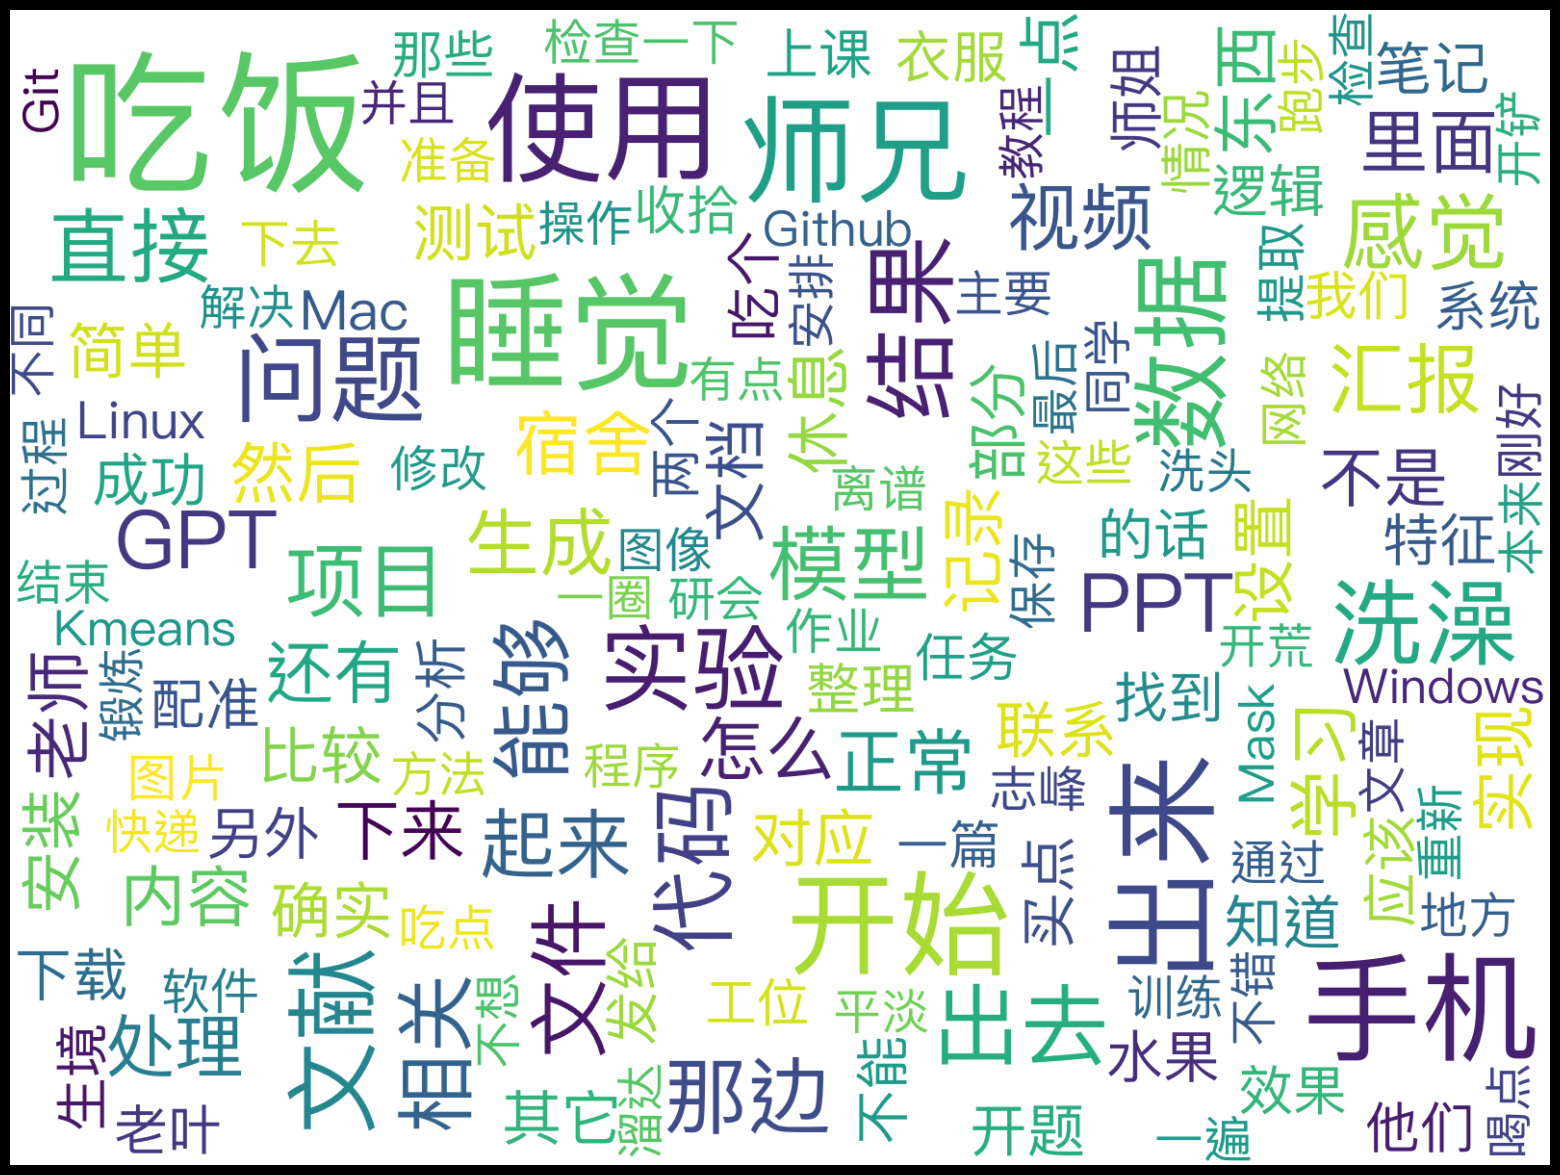

In [48]:
markdown_dir = Path('/Users/choose/Downloads/joplin/日常/光荣在于平淡')  # 替换为你的 Markdown 文件目录
if markdown_dir.exists():
    multi_markdown_file_wordcloud_generate(markdown_dir=markdown_dir)

end
